# Import

In [1]:
from interpret import *
from tint.metrics import mse, mae
import tint, captum, gc
from tqdm import tqdm
import pandas as pd
from utils.explainer import *
from exp.exp_interpret import *

import matplotlib.pyplot as plt
from exp.plot_config import *
%matplotlib inline

# Util

In [7]:
from data.uea import collate_fn

# min max scale a torch tensor across a dimension
def min_max_scale(a, dim=1, absolute=True):
    if absolute: a = a.abs()
    min_values = a.min(dim=dim, keepdims=True).values
    max_values = a.max(dim=dim, keepdims=True).values

    scaled = (a - min_values)/(max_values - min_values)
    scaled[scaled!=scaled] = 0
    return scaled 
    

def normalize_feature(attr, axis=(2, 3)):
    temp = abs(attr)
    temp -= np.min(temp, axis=axis, keepdims=True)
    maximum = np.max(temp, axis=axis, keepdims=True)
    temp /= maximum
    temp[np.isnan(temp)] = 0
    temp[~np.isfinite(temp)] = 0
    
    return temp

def prepare_input(
    data, device, args
):
    if args.task_name == 'classification':
        batch_x, batch_y, padding_mask = data
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = data
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

def prepare_from_dataset(data, device, args):
    if args.task_name == 'classification':
        # already converted to tensor from numpy
        batch_x, batch_y, padding_mask = collate_fn(data)
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = [
            torch.stack(
                [
                    torch.tensor(d[i], dtype=float, device=device) 
                    for d in data
                ]
            ) 
            for i in range(4)
        ]
        batch_x = torch.tensor(batch_x).float().to(device)
        batch_y = torch.tensor(batch_y).float().to(device)

        batch_x_mark = torch.tensor(batch_x_mark).float().to(device)
        batch_y_mark = torch.tensor(batch_y_mark).float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

# Arguments

In [2]:
parser = get_parser()

argv = """
  --explainers feature_ablation occlusion augmented_occlusion winIT tsr wtsr \
  --task_name classification \
  --data mimic \
  --itr_no 1 \
  --root_path ./dataset/mimic_iii/ \
  --data_path mimic_iii.pkl \
  --metrics auc accuracy cross_entropy \
  --model Crossformer --n_features 31
""".split()

# argv = """
#   --task_name long_term_forecast \
#   --explainers feature_ablation occlusion augmented_occlusion winIT tsr wtsr \
#   --root_path ./dataset/traffic/ \
#   --data_path traffic.csv \
#   --model Crossformer \
#   --itr_no 1 \
#   --features S \
#   --seq_len 96 \
#   --label_len 12 \
#   --pred_len 24 \
#   --n_features 1
# """.split()
args = parser.parse_args(argv)

# only evaluate on test
args.flag = 'test'
# Disable cudnn if using cuda accelerator.
# Please see https://captum.ai/docs/faq#how-can-i-resolve-cudnn-rnn-backward-error-for-rnn-or-lstm-network
# args.use_gpu = False
initial_setup(args)

# Initialize

## Experiment

In [3]:
if args.task_name == 'classification': Exp = Exp_Classification
else: Exp = Exp_Long_Term_Forecast
exp = Exp(args)  # set experiments

# should be test or validation data
dataset, dataloader = exp._get_data(args.flag)
exp.load_best_model()

model = exp.model
_ = model.eval()
# model.zero_grad()

Use GPU: cuda:0
train 18390
test 2299
Experiments will be saved in ./results\mimic_iii_Crossformer\1
test 2299
Loading model from ./results\mimic_iii_Crossformer\1\checkpoint.pth


In [4]:
example_no = 0
if args.data_path == 'mimic_iii.pkl':
    first_dead_patient = 0
    while True:
        if first_dead_patient >= len(dataset): break
        if dataset[first_dead_patient][1].item() == 1: break
        first_dead_patient += 1
        
    if first_dead_patient>= len(dataset):
        raise Exception(f'No dead patient in {args.flag}')
    else:
        print(f'First dead patient: {first_dead_patient}')
    example_no = first_dead_patient
else:
    example_no = np.random.randint(0, len(dataset)-1)
    print(f'Randomly chosen {example_no}')

First dead patient: 11


## Explainer

In [5]:
from exp.exp_interpret import Exp_Interpret

explainers_map = dict() 
for name in exp.args.explainers:
    explainer = Exp_Interpret.initialize_explainer(
        name, exp.model, exp.args, exp.device, dataloader
    ) 
    explainers_map[name] = explainer

# Batch Evaluate

In [69]:
# results = []

# result_columns = ['batch_index', 'explainer', 'metric', 'area', 'comp', 'suff']

# progress_bar = tqdm(
#     enumerate(dataloader), total=len(dataloader), disable=False
# )

# for batch_index, data in progress_bar:
#     # get inputs
#     inputs, additional_forward_args, _ = prepare_input(
#         data, exp.device, args
#     )
        
#     # baseline must be a scaler or tuple of tensors with same dimension as input
#     baselines = get_baseline(inputs, args.baseline_mode)
    
#     # interpret
#     for name in args.explainers:
#         explainer = explainers_map[name]
        
#         # get attributions
#         if args.task_name == 'classification':
#             attr = compute_attr(
#                 inputs, baselines, explainer, 
#                 additional_forward_args, args
#             )
#         else:
#             attr = compute_attr(
#                 inputs, baselines, explainer, 
#                 additional_forward_args, args
#             )
    
#         # evaluate
#         for area in args.areas:
#             for metric_name in args.metrics:
#                 metric = expl_metric_map[metric_name]
#                 error_comp = metric(
#                     model, inputs=inputs, 
#                     attributions=attr, baselines=baselines, 
#                     additional_forward_args=additional_forward_args,
#                     topk=area, mask_largest=True
#                 )
                
#                 error_suff = metric(
#                     model, inputs=inputs, 
#                     attributions=attr, baselines=baselines, 
#                     additional_forward_args=additional_forward_args,
#                     topk=area, mask_largest=False
#                 )
           
#                 result_row = [batch_index, name, metric_name, area, error_comp, error_suff]
#                 # print(result_row)
#                 results.append(result_row)

In [70]:
# results_df = pd.DataFrame(results, columns=result_columns)
# results_df = results_df.groupby(
#     ['explainer', 'metric', 'area']
# )[['comp', 'suff']].aggregate('mean').reset_index()

# # results_df.round(6).to_csv(os.path.join(result_folder, 'interpretation_results.csv'), index=False)
# print(results_df)

# Single Evaluate

## Input

In [8]:
# inputs, additional_forward_args, labels = prepare_input(
#     next(iter(dataloader)), exp.device, args
# )
if args.task_name == 'classification':
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[example_no]], exp.device, args
    )
else: 
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[example_no]], exp.device, args
    )
baselines = get_baseline(inputs, args.baseline_mode)

## Explainer

In [72]:
# explainer = FeatureAblation(model)
# explainer = explainers_map[name]
attr_map = dict()

for name in exp.args.explainers:
    print(name)
    explainer = explainers_map[name]
    attr = compute_attr(
        name, inputs, baselines, explainer, 
        additional_forward_args, args,
        avg_attr=False
    )
        
    if args.task_name == 'classification':
        attr_numpy = attr.detach().cpu().numpy()
        attr_normed = normalize_feature(attr_numpy)
    else:
        attr_numpy = tuple([a.detach().cpu().numpy() for a in attr])
        attr_normed = tuple([normalize_feature(a) for a in attr_numpy])

    attr_map[name] = (attr, attr_normed)

feature_ablation
augmented_occlusion
deep_lift
winIT
tsr
wtsr


### Visualize

In [74]:
sample_no = 0
samples = 1
target = 1
cmap='binary' # binary, RdYlGn, grey, hot

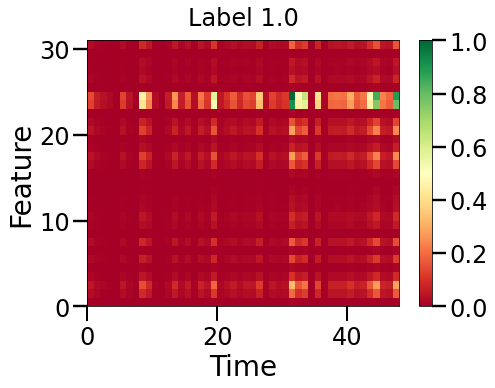

In [ ]:
cmap = 'RdYlGn' # binary, RdYlGn, grey, hot
fig, axes = plt.subplots(1, samples, figsize =(min(18, 7*samples), 5.5))

if samples ==1:
    psm = axes.pcolormesh(
        attr_normed[0, target].T, 
        cmap=cmap, # rasterized=True, # vmin=0, vmax=1
    )
    fig.colorbar(psm, ax=axes)
    axes.set_xlabel('Time')
    axes.set_ylabel('Feature')
    axes.title.set_text(f'Label {labels[0].item()}')
else:
    for sample_no in range(samples):
        psm = axes[sample_no].pcolormesh(
            attr_normed[sample_no, target].T, 
            cmap=cmap, # rasterized=True, # vmin=0, vmax=1
        )
        fig.colorbar(psm, ax=axes[sample_no])
        axes[sample_no].set_xlabel('Time')
        axes[sample_no].set_ylabel('Feature')
        axes[sample_no].title.set_text(f'Sample {sample_no+1}, Label {labels[sample_no].item()}')

fig.tight_layout()
plt.show()

### Evaluate

In [13]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=attr[:, target], baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=attr[:, target], baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')

0.05, auc, 0, 0
0.05, accuracy, 1, 1
0.05, cross_entropy, 0.0557, 0.236
0.075, auc, 0, 0
0.075, accuracy, 1, 1
0.075, cross_entropy, 0.0572, 0.225
0.1, auc, 0, 0
0.1, accuracy, 1, 1
0.1, cross_entropy, 0.0458, 0.221
0.15, auc, 0, 0
0.15, accuracy, 1, 1
0.15, cross_entropy, 0.0514, 0.188


## WTSR

In [14]:
tsr_explainer = WTSR(FeatureAblation(model))

In [15]:
if args.task_name == 'classification':
    tsr_attr = compute_tsr_attr(
        args, tsr_explainer, inputs=inputs, 
        sliding_window_shapes=(1,1), 
        strides=1, baselines=baselines,
        additional_forward_args=additional_forward_args,
        avg_attr=False
    )

    tsr_attr_numpy = tsr_attr.detach().cpu().numpy()
    tsr_attr_normed  = normalize_feature(tsr_attr_numpy)
else:
    tsr_attr = compute_tsr_attr(
        args, tsr_explainer, inputs=inputs, 
        sliding_window_shapes=(1,1), 
        strides=1, baselines=baselines,
        additional_forward_args=additional_forward_args,
        avg_attr=False
    )
    tsr_attr_numpy = tuple([a.detach().cpu().numpy() for a in tsr_attr])
    tsr_attr_normed = normalize_feature(tsr_attr_numpy)

In [16]:
if len(tsr_attr.shape) == 4:
    tsr_attr_avg = torch.mean(tsr_attr, dim=1) # take mean across target dimension
else:
    tsr_attr_avg = tsr_attr

### Evaluate

In [17]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=tsr_attr_avg, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=tsr_attr_avg, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')

0.05, auc, 0, 0
0.05, accuracy, 1, 1
0.05, cross_entropy, 0.0398, 0.229
0.075, auc, 0, 0
0.075, accuracy, 1, 1
0.075, cross_entropy, 0.0413, 0.231
0.1, auc, 0, 0
0.1, accuracy, 1, 1
0.1, cross_entropy, 0.0464, 0.224
0.15, auc, 0, 0
0.15, accuracy, 1, 1
0.15, cross_entropy, 0.0476, 0.199


# Visualization

In [22]:
sample_no = 0
target = 1
cmap='binary' # binary, RdYlGn, grey, hot

## Single feature

In [45]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# feature_no = 0

# if type(attr_normed) == tuple:
#     attr_normed = attr_normed[0]
    
# axes[0].plot(attr_normed[sample_no, target, :, feature_no], label='FA')
# axes[0].legend()
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('Feature importance')

# axes[1].plot(tsr_attr_normed[sample_no, target, :, feature_no], label='WTSR + FA')
# axes[1].legend()
# axes[1].set_xlabel('Time')
    
# fig.tight_layout()
# # plt.savefig('results/single_example.jpg', dpi=200)
# plt.show()

## All features

### Single target

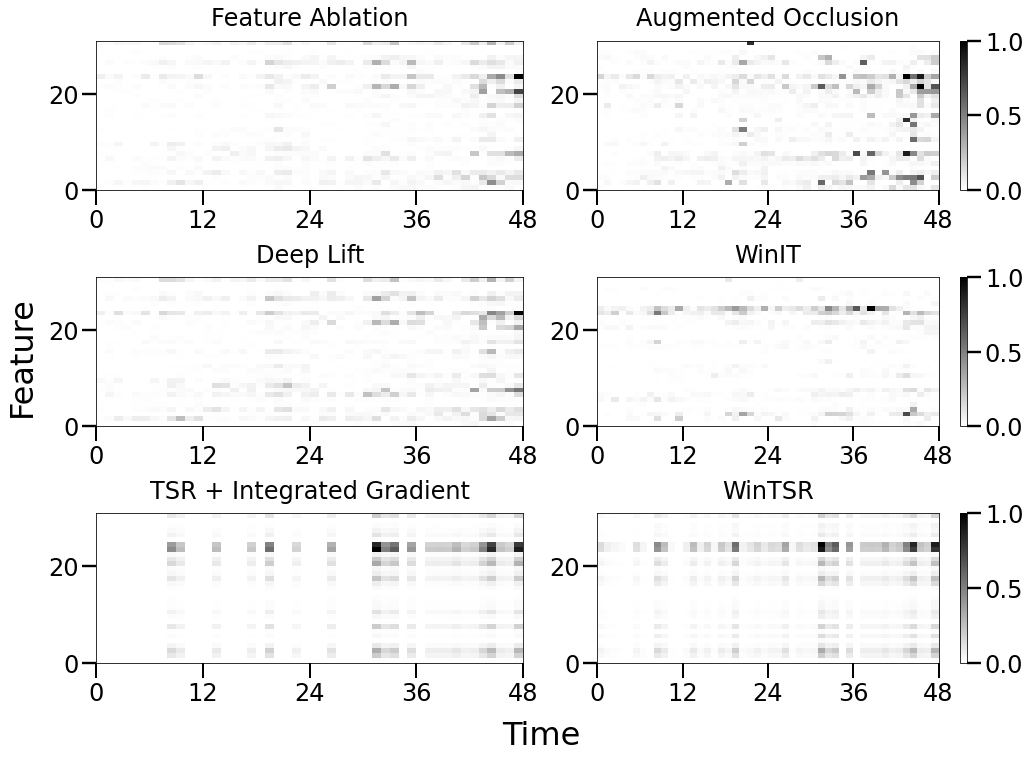

In [87]:
n = len(args.explainers)
if args.data_path == 'mimic_iii.pkl':
    fig, axes = plt.subplots(n//2, 2, figsize =(14, 10))
else:
    fig, axes = plt.subplots(n//2, 2, figsize =(12, 8))

for row in range(n//2):
    for col in range(2):
        feature_no = row * 2 + col
        name = args.explainers[feature_no]
        attr_normed = attr_map[name][1]
        if type(attr_normed) == tuple:
            # concatenate across feature dimension
            # attr_normed = np.concatenate(attr_normed, axis=-1)
            
            # only use the encoder features
            attr_normed = attr_normed[0]
            
        # attr_normed = np.mean(attr_normed, axis=1)
        ax = axes[row][col]
        psm = ax.pcolormesh(
            attr_normed[sample_no, target].T, 
            cmap=cmap, # rasterized=True, # vmin=0, vmax=1
        )
            
        if col == 1:
            fig.colorbar(psm, ax=ax)
        # im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
        # axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
        # name = explainer_name_map[]
        if name == 'tsr':
            name = 'TSR + Integrated Gradient'
        elif name == 'wtsr':
            name = 'WinTSR'
        elif name == 'winIT': name = 'WinIT'
        else:
            name = explainer_name_map[name].get_name()
        ax.set_title(name)
        if args.data_path == 'mimic_iii.pkl':
            ax.xaxis.set_major_locator(MultipleLocator(base=12))
        else:
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
        # ax.set_ylabel('Feature')

fig.tight_layout()
fig.supylabel('Feature', fontsize=32, x=-.03)
fig.supxlabel('Time', fontsize=32, y=-0.05)
# plt.suptitle('Heat map of feature importance scores')
plt.savefig(f'{exp.output_folder}/heatmap.jpg', dpi=200, bbox_inches="tight")
plt.show()

### Avg over multiple target

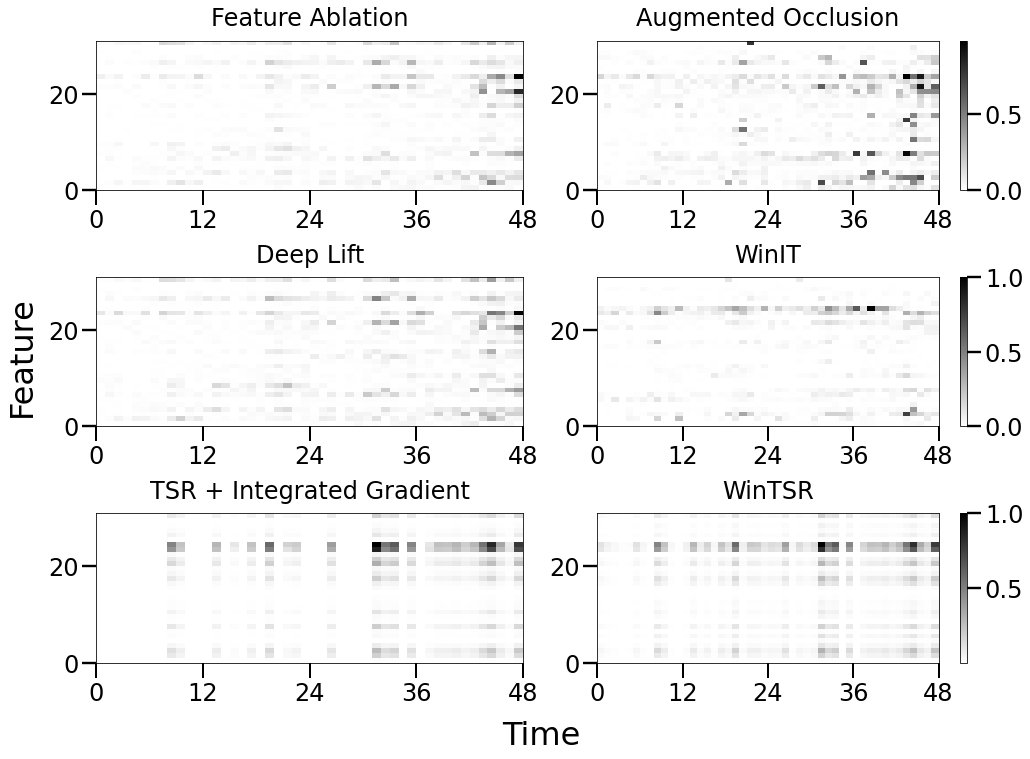

In [86]:
n = len(args.explainers)
if args.data_path == 'mimic_iii.pkl':
    fig, axes = plt.subplots(n//2, 2, figsize =(14, 10), width_ratios=[1, 1.1])
else:
    fig, axes = plt.subplots(n//2, 2, figsize =(12, 8), width_ratios=[1, 1.1])

for row in range(n//2):
    for col in range(2):
        feature_no = row * 2 + col
        name = args.explainers[feature_no]
        attr_normed = attr_map[name][1]
        if type(attr_normed) == tuple:
            # concatenate across feature dimension
            # attr_normed = np.concatenate(attr_normed, axis=-1)
            
            # only use the encoder features
            attr_normed = attr_normed[0]
            
        # attr_normed = np.mean(attr_normed, axis=1)
        ax = axes[row][col]

        psm = ax.pcolormesh(
            attr_normed[sample_no].mean(axis=0).T, 
            cmap=cmap, # rasterized=True, # vmin=0, vmax=1
        )
            
        if col == 1:
            fig.colorbar(psm, ax=ax)
        # im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
        # axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
        # name = explainer_name_map[]
        if name == 'tsr':
            name = 'TSR + Integrated Gradient'
        elif name == 'wtsr':
            name = 'WinTSR'
        elif name == 'winIT': name = 'WinIT'
        else:
            name = explainer_name_map[name].get_name()
        ax.set_title(name)
        if args.data_path == 'mimic_iii.pkl':
            ax.xaxis.set_major_locator(MultipleLocator(base=12))
        else:
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
        # ax.set_ylabel('Feature')

fig.tight_layout()
fig.supylabel('Feature', fontsize=32, x=-.03)
fig.supxlabel('Time', fontsize=32, y=-0.05)
# plt.suptitle('Heat map of feature importance scores')
plt.savefig(f'{exp.output_folder}/heatmap_avg_target.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Density plot

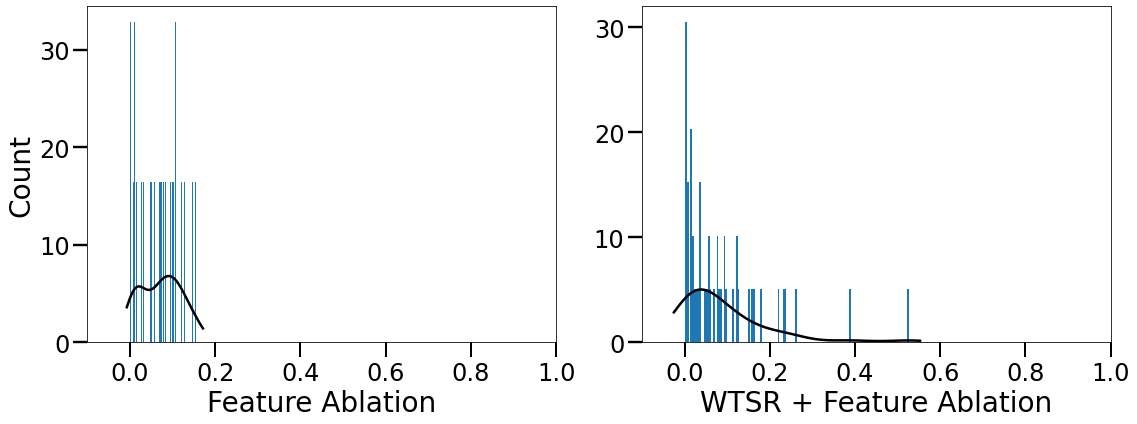

In [37]:
import scipy.stats as st
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
n_bins = 128

dist1 = attr_normed[:, target, :, feature_no].flatten()
dist2 = tsr_attr_normed[:, target, :, feature_no].flatten()

_ = axes[0].hist(dist1, bins=n_bins, density=True)
# We can set the number of bins with the *bins* keyword argument.
kde = st.gaussian_kde(dist1)
mn, mx = axes[0].get_xlim()
kde_xs = np.linspace(mn, mx, 100)
axes[0].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
axes[0].set_ylabel('Count')
axes[0].set_xlabel(f'{explainer.get_name()}')
axes[0].set_xlim(-0.1, 1)

_ = axes[1].hist(dist2, bins=n_bins, density=True)
axes[1].set_xlabel(f'WTSR + {explainer.get_name()}')
kde = st.gaussian_kde(dist2)
mn, mx = axes[1].get_xlim()
kde_xs = np.linspace(mn, mx, 100)
axes[1].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
axes[1].set_xlim(-0.1, 1)
# plt.suptitle('Histogram and density plot of feature importance scores')
fig.tight_layout()
# plt.savefig('results/density.jpg', dpi=200)

# WIP

In [10]:
from typing import cast
batch, time_steps, features = inputs.shape
initial_eval = model(inputs, *additional_forward_args)

# get as a 2D tensor (if it is not a scalar)
if isinstance(initial_eval, torch.Tensor):
    initial_eval = initial_eval.reshape(1, -1)
    num_outputs = initial_eval.shape[1]
else:
    num_outputs = 1
attrib_type = cast(
    torch.dtype,
    initial_eval.dtype
    if isinstance(initial_eval, Tensor)
    else type(initial_eval),
)

## Time relevance

In [13]:
baselines.shape

torch.Size([1, 48, 31])

In [19]:
inputs.unsqueeze(0).repeat(3, 1, 1, 1).shape

torch.Size([3, 1, 48, 31])

In [16]:
time_relevance = torch.zeros(
    (batch, num_outputs, time_steps),
    dtype=attrib_type, device=inputs.device
)
ablated_inputs = inputs.clone()
for time_step in range(time_steps):
    ablated_inputs[:, time_step] = baselines[:, time_step]
    modified_eval = model(ablated_inputs, *additional_forward_args)
    eval_diff = abs(initial_eval - modified_eval)
    time_relevance[:, :, time_step] = eval_diff
    # if time_step == 0:
        
    # else:
    #     time_relevance[:, :, time_step] = abs(eval_diff - time_relevance[:, :, time_step-1])
    
time_relevance

tensor([[[0.0030, 0.0049, 0.0029, 0.0026, 0.0024, 0.0034, 0.0010, 0.0016,
          0.0108, 0.0082, 0.0159, 0.0385, 0.0352, 0.0254, 0.0304, 0.0239,
          0.0248, 0.0146, 0.0306, 0.0492, 0.0767, 0.0887, 0.0932, 0.1093,
          0.1106, 0.1071, 0.0971, 0.1025, 0.1040, 0.1008, 0.1113, 0.0933,
          0.0818, 0.0802, 0.0794, 0.0743, 0.0908, 0.0991, 0.1045, 0.0922,
          0.0884, 0.0876, 0.0985, 0.1104, 0.0957, 0.1293, 0.1564, 0.4875],
         [0.0046, 0.0068, 0.0044, 0.0045, 0.0052, 0.0070, 0.0046, 0.0019,
          0.0122, 0.0061, 0.0122, 0.0329, 0.0297, 0.0216, 0.0264, 0.0201,
          0.0206, 0.0130, 0.0291, 0.0478, 0.0759, 0.0977, 0.1018, 0.1198,
          0.1205, 0.1175, 0.1089, 0.1153, 0.1186, 0.1149, 0.1254, 0.1059,
          0.0989, 0.0999, 0.1025, 0.1054, 0.1212, 0.1269, 0.1320, 0.1239,
          0.1218, 0.1224, 0.1342, 0.1532, 0.1372, 0.1713, 0.2045, 0.4387]]],
       device='cuda:0', grad_fn=<CopySlices>)

In [157]:
time_relevance = torch.zeros(
    (batch, num_outputs, time_steps),
    dtype=attrib_type, device=inputs.device
)
ablated_inputs = inputs.clone()
for time_step in range(time_steps):
    ablated_inputs[:, :time_step+1] = baselines[:, :time_step+1]

    attr_ = compute_attr(
        ablated_inputs, baselines, explainer, 
        additional_forward_args, args,
        avg_attr=False
    )
    time_relevance[:, :, time_step] = (attr - attr_).abs().sum(dim=(2, 3))
    
    # no need to revert back to original time series since all previous steps are ablated
    # ablated_inputs[:, :time_step+1] = inputs[:, :time_step+1]
    
time_relevance

tensor([[[ 0.4865,  0.7340,  1.1564,  1.3058,  1.4821,  1.7018,  2.1066,
           2.1046,  2.4366,  2.6909,  2.8821,  3.1309,  3.4124,  3.6452,
           3.8315,  3.9589,  4.1558,  4.2678,  4.5489,  5.0302,  5.4719,
           5.6303,  6.0751,  6.5951,  6.8844,  7.5547,  7.9247,  8.4373,
           8.6372,  9.1400,  9.4964,  9.9309, 10.2036, 10.6495, 11.0622,
          11.2936, 11.5255, 11.7845, 11.9606, 12.3428, 12.7176, 12.9820,
          13.3904, 13.9393, 14.4435, 14.6985, 15.0176, 15.5050],
         [ 0.3953,  0.7042,  1.1612,  1.3159,  1.5753,  1.7752,  2.1468,
           2.1363,  2.4708,  2.7729,  2.9481,  3.1501,  3.5593,  3.8269,
           4.0654,  4.2282,  4.4359,  4.5472,  4.7999,  5.1587,  5.5141,
           5.6408,  6.1218,  6.3898,  6.7098,  7.2614,  7.6166,  8.1984,
           8.3187,  9.0002,  9.4634, 10.0114, 10.3679, 10.7904, 11.1180,
          11.3246, 11.6295, 11.7664, 12.0588, 12.4630, 12.7932, 13.0786,
          13.4296, 13.9326, 14.5039, 15.1528, 15.8264, 16.4

In [155]:
tsr_sliding_window_shapes = tuple(
    (1, inputs.shape[2])
)
print(tsr_sliding_window_shapes)

feature_sliding_window_shapes = tuple(
    (inputs.shape[1], 1)
)
print(feature_sliding_window_shapes)

(1, 31)
(48, 1)


In [ ]:
# tsr_explainer.attribute.__wrapped__(
#     self,
#     inputs=inputs,
#     sliding_window_shapes=tsr_sliding_window_shapes,
#     strides=None,
#     baselines=baselines,
#     target=target,
#     additional_forward_args=additional_forward_args,
#     perturbations_per_eval=perturbations_per_eval,
#     attributions_fn=abs,
#     show_progress=show_progress,
#     #TODO: uncomment after new release
#     # kwargs_run_forward=kwargs,
# )

In [ ]:
# FeatureAblation.attribute.__wrapped__(
#     explainer,
#     inputs,
#     baselines=baselines,
#     target=target,
#     additional_forward_args=additional_forward_args,
#     perturbations_per_eval=1,
#     sliding_window_tensors=tsr_sliding_window_shapes,
#     shift_counts=tuple(shift_counts),
#     is_above_threshold=is_above_threshold,
#     strides=strides,
#     attributions_fn=abs,
#     show_progress=show_progress,
#     #TODO: uncomment after new release
#     # kwargs_run_forward=kwargs,
# )

In [158]:
# normalize along the time axis
time_relevance -= time_relevance.min(dim=-1, keepdim=True).values
time_relevance /= time_relevance.sum(dim=-1, keepdim=True)

# remove nans and infs
time_relevance[
    (time_relevance != time_relevance) 
    | (time_relevance == torch.inf)
] = 0
time_relevance

tensor([[[0.0000, 0.0008, 0.0020, 0.0025, 0.0030, 0.0037, 0.0050, 0.0049,
          0.0060, 0.0067, 0.0073, 0.0081, 0.0089, 0.0097, 0.0102, 0.0106,
          0.0112, 0.0116, 0.0124, 0.0139, 0.0152, 0.0157, 0.0171, 0.0187,
          0.0196, 0.0216, 0.0227, 0.0243, 0.0249, 0.0265, 0.0276, 0.0289,
          0.0297, 0.0311, 0.0323, 0.0330, 0.0338, 0.0345, 0.0351, 0.0363,
          0.0374, 0.0382, 0.0395, 0.0411, 0.0427, 0.0435, 0.0444, 0.0459],
         [0.0000, 0.0009, 0.0023, 0.0027, 0.0035, 0.0041, 0.0052, 0.0052,
          0.0062, 0.0071, 0.0076, 0.0082, 0.0094, 0.0102, 0.0110, 0.0114,
          0.0121, 0.0124, 0.0131, 0.0142, 0.0153, 0.0157, 0.0171, 0.0179,
          0.0188, 0.0205, 0.0215, 0.0233, 0.0236, 0.0257, 0.0271, 0.0287,
          0.0298, 0.0310, 0.0320, 0.0326, 0.0335, 0.0339, 0.0348, 0.0360,
          0.0370, 0.0378, 0.0389, 0.0404, 0.0421, 0.0440, 0.0460, 0.0478]]],
       device='cuda:0')

## Feature relevance

In [141]:
# batch x outputs x features
feature_relevance = torch.zeros(
    (batch, num_outputs, features),
    dtype=attrib_type, device=inputs.device
)
ablated_inputs = inputs.clone()
for feature in range(features):
    ablated_inputs[:,:, feature] = baselines[:, :, feature]
    modified_eval = model(ablated_inputs, *additional_forward_args)
    feature_relevance[:, :, feature] = abs(initial_eval - modified_eval)
    
feature_relevance

tensor([[[0.3046, 0.6312, 0.7505, 0.0037, 0.0489, 0.0204, 0.0016, 0.2463,
          0.2314, 0.1688, 0.2733, 0.1080, 0.2316, 0.1978, 0.1757, 0.2529,
          0.2998, 0.2593, 0.1717, 0.1896, 0.0284, 0.0344, 0.2119, 0.0650,
          0.0562, 0.0017, 0.1383, 0.0453, 0.1988, 1.0306, 1.0489],
         [0.2263, 0.1596, 0.0441, 1.0356, 0.9799, 0.8971, 0.9546, 0.8465,
          0.8322, 0.7747, 0.8378, 0.7688, 0.8857, 1.0431, 0.9768, 1.0877,
          1.1373, 1.0019, 0.7035, 0.6341, 0.4887, 0.5295, 0.6361, 0.4414,
          0.4289, 0.4379, 0.3168, 0.4257, 0.4281, 1.3878, 1.3612]]],
       device='cuda:0', grad_fn=<CopySlices>)

In [163]:
feature_relevance = torch.zeros(
    (batch, num_outputs, features),
    dtype=attrib_type, device=inputs.device
)
ablated_inputs = inputs.clone()
for feature in range(features):
    ablated_inputs[:,:, feature] = baselines[:, :, feature]
    attr_ = compute_attr(
        ablated_inputs, baselines, explainer, 
        additional_forward_args, args,
        avg_attr=False
    )
    feature_relevance[:, :, feature] = (attr - attr_).abs().sum(dim=(2, 3))
    # need to revert back to original time series
    ablated_inputs[:,:, feature] = inputs[:, :, feature]
    
feature_relevance

tensor([[[ 8.4245, 11.0854,  6.0214,  8.5742,  1.9025,  1.2846,  1.7730,
           6.4384,  1.2214,  2.6103,  3.5909,  4.4128,  3.5242,  1.7336,
           1.4041,  3.1436,  2.7753,  2.0733,  6.2760,  2.2210,  9.6117,
           2.2883,  4.8373,  3.2102,  3.5659,  2.0157,  1.1715,  4.6825,
           5.4674,  6.9938,  1.8379],
         [ 8.8179, 11.5781,  5.8444,  8.8700,  2.0744,  1.3633,  1.8777,
           6.6646,  1.3282,  2.9302,  4.0467,  5.0797,  3.1001,  1.8469,
           1.7510,  3.7250,  3.1429,  2.2385,  5.9870,  2.3305,  9.8434,
           2.0446,  4.5538,  3.7351,  3.6904,  2.0748,  1.3878,  5.2359,
           5.8249,  7.4956,  2.1351]]], device='cuda:0')

In [164]:
# normalize along the time axis
feature_relevance -= feature_relevance.min(dim=-1, keepdim=True).values
feature_relevance /= feature_relevance.sum(dim=-1, keepdim=True)

# remove nans and infs
feature_relevance[
    (feature_relevance != feature_relevance) 
    | (feature_relevance == torch.inf)
] = 0
feature_relevance

tensor([[[0.0807, 0.1103, 0.0540, 0.0824, 0.0081, 0.0013, 0.0067, 0.0586,
          0.0006, 0.0160, 0.0269, 0.0361, 0.0262, 0.0063, 0.0026, 0.0219,
          0.0178, 0.0100, 0.0568, 0.0117, 0.0939, 0.0124, 0.0408, 0.0227,
          0.0266, 0.0094, 0.0000, 0.0391, 0.0478, 0.0648, 0.0074],
         [0.0819, 0.1121, 0.0494, 0.0825, 0.0082, 0.0004, 0.0060, 0.0584,
          0.0000, 0.0175, 0.0297, 0.0410, 0.0194, 0.0057, 0.0046, 0.0262,
          0.0198, 0.0100, 0.0509, 0.0110, 0.0931, 0.0078, 0.0353, 0.0263,
          0.0258, 0.0082, 0.0007, 0.0427, 0.0492, 0.0674, 0.0088]]],
       device='cuda:0')

## Merge relevance

In [173]:
wtsr_attr = torch.zeros(
    (batch, num_outputs, time_steps, features),
    dtype=attrib_type, device=inputs.device
)
for time in range(time_steps):
    for feature in range(features):
        a = feature_relevance[:, :, feature]
        b = time_relevance[:, :, time]
        # wtsr_attr[:, :, time, feature] = a + b - a * b
        wtsr_attr[:, :, time, feature] = a + b - attr[:, :, time, feature]
        
wtsr_attr_numpy = wtsr_attr.detach().cpu().numpy()
wtsr_attr_normed = normalize_feature(wtsr_attr_numpy)

avg_wtsr_attr = wtsr_attr.mean(dim=1)

In [178]:
wtsr_attr_normed = normalize_feature(wtsr_attr_numpy)

## Visualize

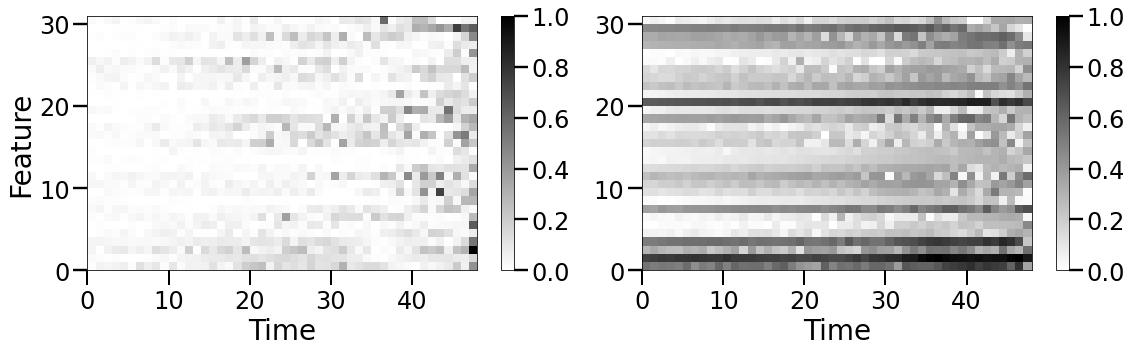

In [179]:
fig, axes = plt.subplots(1, 2, figsize =(16, 5))

psm = axes[0].pcolormesh(
    attr_normed[example_no, target].T, 
    cmap=cmap, # rasterized=True, # vmin=0, vmax=1
)
fig.colorbar(psm, ax=axes[0])
# im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
# axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Feature')


psm = axes[1].pcolormesh(
    wtsr_attr_normed[example_no, target].T, 
    cmap=cmap, # rasterized=True, # vmin=0, vmax=1
)
fig.colorbar(psm, ax=axes[1])
axes[1].set_xlabel('Time')

fig.tight_layout()
# plt.suptitle('Heat map of feature importance scores')
# plt.savefig('results/heatmap.jpg', dpi=200)
plt.show()

## Evaluate

In [170]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=avg_wtsr_attr, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=avg_wtsr_attr, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')

0.05, auc, 0, 0
0.05, accuracy, 1, 1
0.05, cross_entropy, 0.0323, 0.018
0.075, auc, 0, 0
0.075, accuracy, 1, 1
0.075, cross_entropy, 0.0136, 0.0233
0.1, auc, 0, 0
0.1, accuracy, 1, 1
0.1, cross_entropy, 0.00756, 0.022
0.15, auc, 0, 0
0.15, accuracy, 1, 1
0.15, cross_entropy, 0.00406, 0.0354
